# Part 2

This notebook will answer all the questions in part 2

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Dataset Preparation 

First, we define all relevant hyperparameters, then we load the dataset.

After which, we will load the word embeddings and process the data accordingly

In [2]:
BATCH_SIZE = 32

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

### Word Embedding

We load the pre-trained Google News 300 dimension Word2Vec model and obtain a word index to be used later in data processing

In [4]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

In [5]:
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [6]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [7]:
word2vec_model.vector_size

350

### Dataloaders

Once we have the dataset and the word index both loaded, we can proceed with building the dataloaders for batch training. We first prepare the data by tokenizing and padding the data so that they are all of the same length

In [8]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

Once the data is processed, we create dataloaders for the data for batch training

In [9]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Models

Once again, we define all relevant hyperparameters

In [10]:
LR = 0.0001
MODEL_TYPE = "rnn"

## 1. Default RNN

We initialise the model for the default RNN without any extra processing to derive the final sentence representation

In [11]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [12]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode=None
)

Epoch   1/100, Loss: 0.6955, Accuracy: 0.5103
Model saved.
Epoch   2/100, Loss: 0.6914, Accuracy: 0.5235
Model saved.
Epoch   3/100, Loss: 0.6827, Accuracy: 0.5319
Model saved.
Epoch   4/100, Loss: 0.6709, Accuracy: 0.5638
Model saved.
Epoch   5/100, Loss: 0.6553, Accuracy: 0.5544
Epoch   6/100, Loss: 0.6389, Accuracy: 0.5638
Epoch   7/100, Loss: 0.6179, Accuracy: 0.5750
Model saved.
Epoch   8/100, Loss: 0.5986, Accuracy: 0.5675
Epoch   9/100, Loss: 0.5838, Accuracy: 0.5535
Epoch  10/100, Loss: 0.5686, Accuracy: 0.5769
Model saved.
Epoch  11/100, Loss: 0.5538, Accuracy: 0.5713
Epoch  12/100, Loss: 0.5427, Accuracy: 0.5760
Epoch  13/100, Loss: 0.5287, Accuracy: 0.5544
Epoch  14/100, Loss: 0.5215, Accuracy: 0.5553
Epoch  15/100, Loss: 0.5099, Accuracy: 0.5600
Epoch  16/100, Loss: 0.4995, Accuracy: 0.5535
Epoch  17/100, Loss: 0.4902, Accuracy: 0.5366
Epoch  18/100, Loss: 0.4831, Accuracy: 0.5516
Epoch  19/100, Loss: 0.4746, Accuracy: 0.5516
Epoch  20/100, Loss: 0.4684, Accuracy: 0.5356
Ea

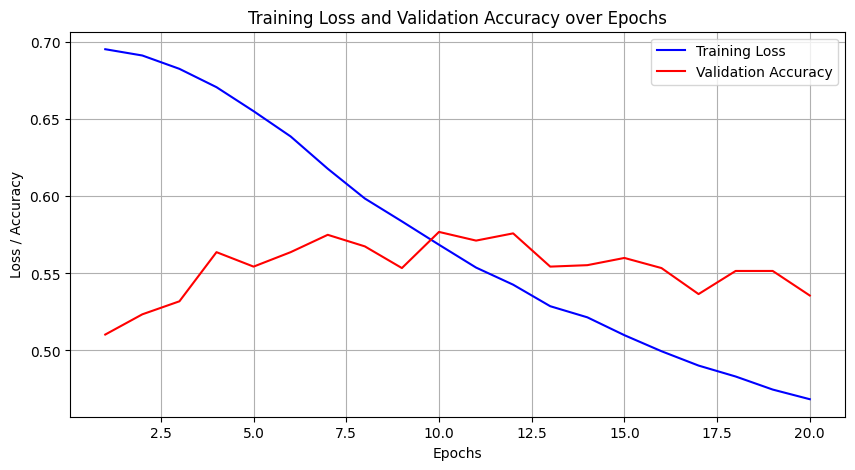

In [13]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [14]:
rnn_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5769


Test the model on the test set to obtain the accuracy

In [15]:
rnn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5657


## 2. Last State RNN

This RNN will pick the hidden vector from the last time step as the sentence representation. This approach assumes that the last hidden state will capture the overall meaning of the sentence

In [16]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [17]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state" # train only the last state
)

Epoch   1/100, Loss: 0.6953, Accuracy: 0.4953
Model saved.
Epoch   2/100, Loss: 0.6907, Accuracy: 0.5084
Model saved.
Epoch   3/100, Loss: 0.6820, Accuracy: 0.5338
Model saved.
Epoch   4/100, Loss: 0.6680, Accuracy: 0.5507
Model saved.
Epoch   5/100, Loss: 0.6550, Accuracy: 0.5478
Epoch   6/100, Loss: 0.6341, Accuracy: 0.5507
Epoch   7/100, Loss: 0.6209, Accuracy: 0.5600
Model saved.
Epoch   8/100, Loss: 0.5995, Accuracy: 0.5657
Model saved.
Epoch   9/100, Loss: 0.5832, Accuracy: 0.5450
Epoch  10/100, Loss: 0.5649, Accuracy: 0.5460
Epoch  11/100, Loss: 0.5523, Accuracy: 0.5638
Epoch  12/100, Loss: 0.5383, Accuracy: 0.5553
Epoch  13/100, Loss: 0.5280, Accuracy: 0.5497
Epoch  14/100, Loss: 0.5162, Accuracy: 0.5450
Epoch  15/100, Loss: 0.5057, Accuracy: 0.5385
Epoch  16/100, Loss: 0.4937, Accuracy: 0.5347
Epoch  17/100, Loss: 0.4823, Accuracy: 0.5413
Epoch  18/100, Loss: 0.4804, Accuracy: 0.5366
Early stopping triggered after 18 epochs.
Training ended, loading best model...
Model loaded.


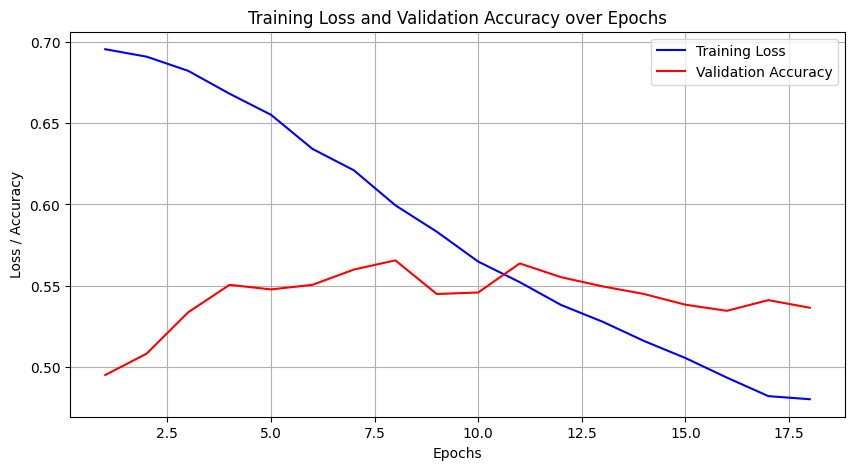

In [18]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [19]:
last_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5657


Test the model on the test set to obtain the accuracy

In [20]:
last_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5760


## 3. Mean Pooling RNN

This RNN will use the average of all hidden vectors as the sentence representation. This captures information across the whole sentence by averaging the all the words' contributions

In [21]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [22]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool" # train only the mean pool
)

Epoch   1/100, Loss: 0.6944, Accuracy: 0.4972
Model saved.
Epoch   2/100, Loss: 0.6918, Accuracy: 0.5094
Model saved.
Epoch   3/100, Loss: 0.6843, Accuracy: 0.5253
Model saved.
Epoch   4/100, Loss: 0.6694, Accuracy: 0.5713
Model saved.
Epoch   5/100, Loss: 0.6543, Accuracy: 0.5535
Epoch   6/100, Loss: 0.6386, Accuracy: 0.5685
Epoch   7/100, Loss: 0.6186, Accuracy: 0.5600
Epoch   8/100, Loss: 0.6019, Accuracy: 0.5750
Model saved.
Epoch   9/100, Loss: 0.5876, Accuracy: 0.5525
Epoch  10/100, Loss: 0.5691, Accuracy: 0.5657
Epoch  11/100, Loss: 0.5534, Accuracy: 0.5657
Epoch  12/100, Loss: 0.5382, Accuracy: 0.5544
Epoch  13/100, Loss: 0.5280, Accuracy: 0.5629
Epoch  14/100, Loss: 0.5154, Accuracy: 0.5478
Epoch  15/100, Loss: 0.5055, Accuracy: 0.5478
Epoch  16/100, Loss: 0.4924, Accuracy: 0.5544
Epoch  17/100, Loss: 0.4854, Accuracy: 0.5488
Epoch  18/100, Loss: 0.4798, Accuracy: 0.5478
Early stopping triggered after 18 epochs.
Training ended, loading best model...
Model loaded.


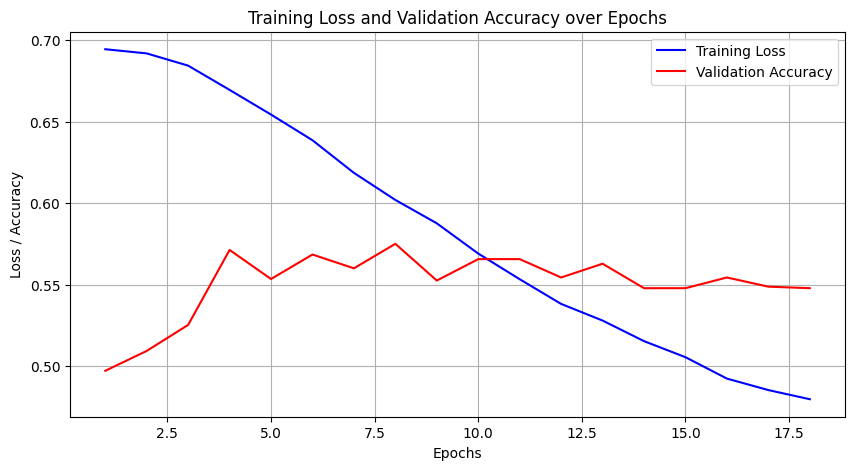

In [23]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [24]:
mean_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5750


Test the model on the test set to obtain the accuracy

In [25]:
mean_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5619


## 4. Max Pool RNN

This RNN will compute the max of all hidden vectors along each dimension. This will effectively use the most significant word as the representation of the sentence

In [26]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [27]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool" # train only the max pool
)

Epoch   1/100, Loss: 0.6937, Accuracy: 0.5103
Model saved.
Epoch   2/100, Loss: 0.6889, Accuracy: 0.5319
Model saved.
Epoch   3/100, Loss: 0.6832, Accuracy: 0.5356
Model saved.
Epoch   4/100, Loss: 0.6661, Accuracy: 0.5629
Model saved.
Epoch   5/100, Loss: 0.6516, Accuracy: 0.5816
Model saved.
Epoch   6/100, Loss: 0.6371, Accuracy: 0.5722
Epoch   7/100, Loss: 0.6235, Accuracy: 0.5760
Epoch   8/100, Loss: 0.6061, Accuracy: 0.5582
Epoch   9/100, Loss: 0.5890, Accuracy: 0.5619
Epoch  10/100, Loss: 0.5750, Accuracy: 0.5741
Epoch  11/100, Loss: 0.5623, Accuracy: 0.5685
Epoch  12/100, Loss: 0.5510, Accuracy: 0.5535
Epoch  13/100, Loss: 0.5362, Accuracy: 0.5694
Epoch  14/100, Loss: 0.5270, Accuracy: 0.5516
Epoch  15/100, Loss: 0.5143, Accuracy: 0.5544
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


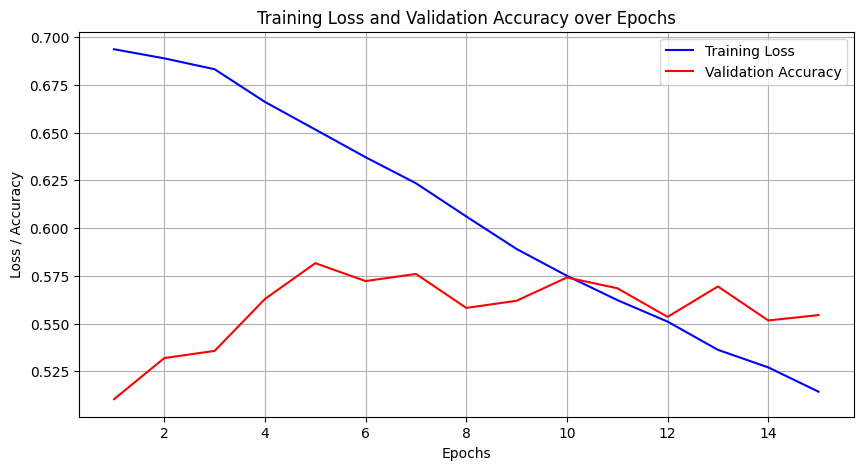

In [28]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [29]:
max_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5816


Test the model on the test set to obtain the accuracy

In [30]:
max_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5985


## 5. Mean and Max Pooled RNN

This RNN will compute the average of both the Mean pooled and Max pooled values. This should be able to smooth out the pros and cons of both Mean Pooling and Max Pooling

In [31]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [32]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6937, Accuracy: 0.5038
Model saved.
Epoch   2/100, Loss: 0.6905, Accuracy: 0.5028
Epoch   3/100, Loss: 0.6827, Accuracy: 0.5263
Model saved.
Epoch   4/100, Loss: 0.6689, Accuracy: 0.5694
Model saved.
Epoch   5/100, Loss: 0.6538, Accuracy: 0.5797
Model saved.
Epoch   6/100, Loss: 0.6357, Accuracy: 0.5769
Epoch   7/100, Loss: 0.6192, Accuracy: 0.5647
Epoch   8/100, Loss: 0.6009, Accuracy: 0.5704
Epoch   9/100, Loss: 0.5846, Accuracy: 0.5694
Epoch  10/100, Loss: 0.5729, Accuracy: 0.5685
Epoch  11/100, Loss: 0.5549, Accuracy: 0.5591
Epoch  12/100, Loss: 0.5425, Accuracy: 0.5600
Epoch  13/100, Loss: 0.5294, Accuracy: 0.5666
Epoch  14/100, Loss: 0.5182, Accuracy: 0.5582
Epoch  15/100, Loss: 0.5090, Accuracy: 0.5356
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


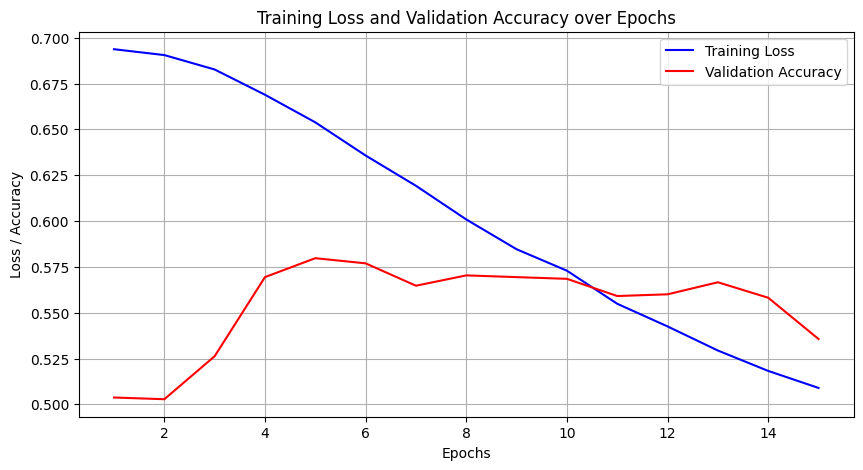

In [33]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [34]:
meanmax_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5797


Test the model on the test set to obtain the accuracy

In [35]:
meanmax_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5947


## 6. Attention RNN

This RNN applies an attention mask on the output vectors

In [36]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [37]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6943, Accuracy: 0.5113
Model saved.
Epoch   2/100, Loss: 0.6894, Accuracy: 0.5563
Model saved.
Epoch   3/100, Loss: 0.6771, Accuracy: 0.5685
Model saved.
Epoch   4/100, Loss: 0.6615, Accuracy: 0.5826
Model saved.
Epoch   5/100, Loss: 0.6473, Accuracy: 0.5929
Model saved.
Epoch   6/100, Loss: 0.6331, Accuracy: 0.5891
Epoch   7/100, Loss: 0.6180, Accuracy: 0.5797
Epoch   8/100, Loss: 0.6032, Accuracy: 0.5600
Epoch   9/100, Loss: 0.5891, Accuracy: 0.5779
Epoch  10/100, Loss: 0.5724, Accuracy: 0.5638
Epoch  11/100, Loss: 0.5559, Accuracy: 0.5553
Epoch  12/100, Loss: 0.5450, Accuracy: 0.5544
Epoch  13/100, Loss: 0.5339, Accuracy: 0.5403
Epoch  14/100, Loss: 0.5194, Accuracy: 0.5432
Epoch  15/100, Loss: 0.5097, Accuracy: 0.5553
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


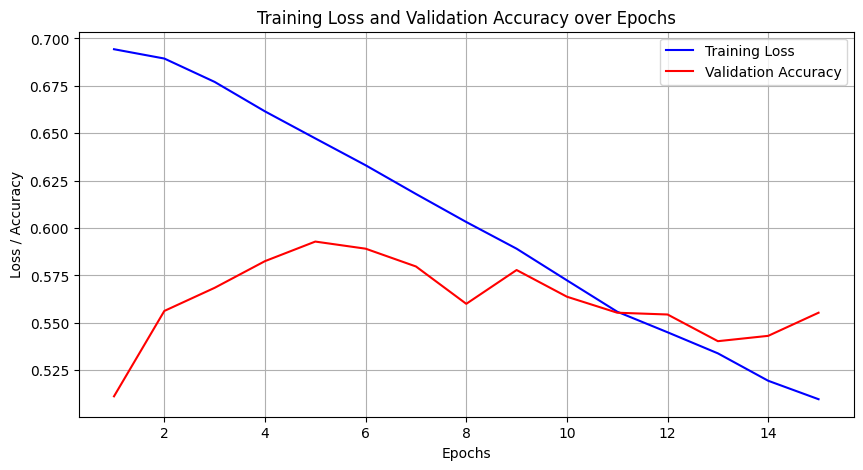

In [38]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [39]:
attn_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5929


Test the model on the test set to obtain the accuracy

In [40]:
attn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6135


# Results

In [41]:
print(f"RNN Test Accuracy:              {rnn_tst_accuracy:.4f}")
print(f"Last State Test Accuracy:       {last_tst_accuracy:.4f}")
print(f"Mean Pool Test Accuracy:        {mean_tst_accuracy:.4f}")
print(f"Max Pool Test Accuracy:         {max_tst_accuracy:.4f}")
print(f"Mean Max Pool Test Accuracy:    {meanmax_tst_accuracy:.4f}")
print(f"Attention Test Accuracy:        {attn_tst_accuracy:.4f}")

RNN Test Accuracy:              0.5657
Last State Test Accuracy:       0.5760
Mean Pool Test Accuracy:        0.5619
Max Pool Test Accuracy:         0.5985
Mean Max Pool Test Accuracy:    0.5947
Attention Test Accuracy:        0.6135


Based on the test accuracies, the RNN that uses the Mean Max Pool has the highest test accuracy.

However, it is worth noting that other models might have a better result if the word embeddings were trained.

Hence, we will be training RNNs with these 3 methods of obtaining sentence representation in part 3:

1. Max Pool
2. Mean Max Pool
3. Attention